In [1]:
from pyironflow import PyironFlow
from pyiron_workflow import Workflow, as_function_node, as_dataclass_node
import typing
import pyiron_nodes as pn
from dataclasses import dataclass, field
from semantikon.typing import u
from semantikon.converter import semantikon_class
from semantikon.converter import parse_input_args, parse_output_args, parse_metadata, meta_to_dict
import pmdco
from pmdco.parsers.default_parsers import *
from pprint import pprint

In [2]:
@dataclass
class Sentence:
    first_word: str = "Hello"
    last_word: str = "World"

@as_function_node("first_word", "second_word")
def SentenceSplitter(sentence: Sentence) -> typing.Tuple[str,str]:
    first = sentence.first_word
    last = sentence.last_word
    print("Sentence: " + first + " " + last)
    return first, last

@as_function_node("sentence")
def WordsCombiner(first_word: str, last_word: str) -> Sentence:
    sentence_dc = Sentence()
    sentence_dc.first_word = first_word
    sentence_dc.last_word = last_word
    print("Sentence: " + sentence_dc.first_word + " " + sentence_dc.last_word)
    return sentence_dc

In [3]:
wf_code = Workflow("test")
wf_code.SentenceSplitter = SentenceSplitter()
wf_code.WordsCombiner = WordsCombiner()
inp1 = wf_code.WordsCombiner.inputs.first_word
inp2 = wf_code.WordsCombiner.inputs.last_word
inp1.connect(wf_code.SentenceSplitter.outputs.second_word)
inp2.connect(wf_code.SentenceSplitter.outputs.first_word)

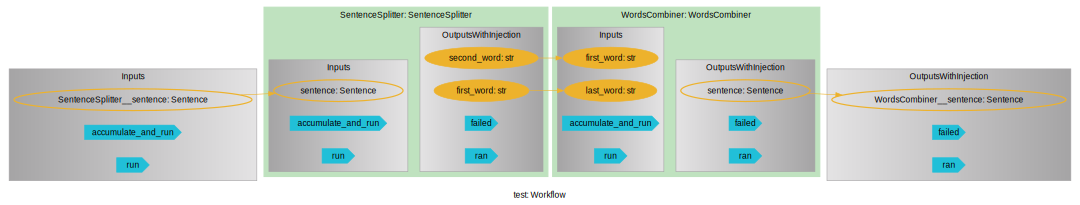

In [27]:
wf_code.draw(size=(15,15))

In [5]:
from pyiron_workflow.node import Node
from pyiron_workflow import Workflow
from rdflib import Graph, Namespace, URIRef, BNode
from rdflib import Literal as rdfLit
import graphviz
from rdflib.namespace import RDF, RDFS
from typing import Callable
from dataclasses import is_dataclass

In [6]:
EX = Namespace("http://pyiron_instances.org/")
NS = Namespace("http://pyiron_classes.org/")

In [28]:
def parse_worklow_recipe(wf: Workflow, parse_nodes=True, parse_software=True, parse_information_flow=True):
    
    from pyiron_workflow.nodes.function import Function
    from pyiron_workflow.nodes.composite import Composite
    import random
    
    g = Graph()
    wf_label = wf.label
    wf_id = str(id(wf) * random.randint(10000,99999) + random.randint(10000,99999))[-16:]

    n_ids = {}
    for k,v in wf.children.items():
        n_label = v.label
        n_id = wf_id + "." + str(id(v) * random.randint(10000,99999) + random.randint(10000,99999))[-16:]
        n_fn = v.node_function
        n_ids[n_label] = n_id

        if isinstance(v, Function):
            n_tp = "atomic"
        elif isinstance(v, Composite):
            n_tp = "workflow"
        else:
            continue

        out_labels = []
        for out in v.outputs:
            out_labels.append(out.label)

        if parse_nodes:
            parse_node(n_fn, n_tp, n_id, n_label, g)
        if parse_software:
            add_software(n_fn, n_tp, n_id, n_label, g)
        if parse_information_flow:
            parse_input_ports(n_fn, n_tp, n_id, n_label, g)
            parse_output_ports_and_objects(n_fn, n_tp, n_id, n_label, out_labels, g)

    for k,v in wf.children.items():
        out_labels = []
        for out in v.outputs:
            out_labels.append(out.label)
        if parse_information_flow:
            make_connections(v, wf_id, n_ids, out_labels, g)

    
    if parse_nodes:
        g.add((EX[wf_id], RDF.type, pmdco.DigitalWorkflowNode().IRI))
        g.add((pmdco.DigitalWorkflowNode().IRI, RDFS.label, rdfLit(pmdco.DigitalWorkflowNode.__name__)))
        g.add((EX[wf_id], RDFS.label, rdfLit(wf.label)))   
        g.add((EX[wf_id + ".process"], pmdco.Executes().IRI, EX[wf_id]))
        g.add((pmdco.Executes().IRI, RDFS.label, rdfLit(pmdco.Executes.__name__)))
        g.add((EX[wf_id + ".process"], RDFS.label, rdfLit(wf.label + ".process")))
        g.add((EX[wf_id + ".process"], RDF.type, pmdco.DigitalWorkflowProcess().IRI))
        g.add((pmdco.DigitalWorkflowProcess().IRI, RDFS.label, rdfLit(pmdco.DigitalWorkflowProcess.__name__)))
        g.add((EX[wf_id + ".process"], pmdco.Realizes().IRI, EX[wf_id + ".plan"]))    
        g.add((EX[wf_id + ".plan"], RDFS.label, rdfLit(wf.label + ".plan")))
        g.add((EX[wf_id + ".plan"], RDF.type, pmdco.DigitalWorkflowPlan().IRI))
        g.add((pmdco.DigitalWorkflowPlan().IRI, RDFS.label, rdfLit(pmdco.DigitalWorkflowPlan.__name__)))

        for k,v in wf.children.items():
            g.add((EX[wf_id], pmdco.HasContinuantPart().IRI, EX[n_ids[v.label]]))
            g.add((pmdco.HasContinuantPart().IRI, RDFS.label, rdfLit(pmdco.HasContinuantPart.__name__)))
            g.add((EX[wf_id + ".process"], pmdco.HasOcccurentPart().IRI, EX[n_ids[v.label] + ".process"]))
            g.add((pmdco.HasOcccurentPart().IRI, RDFS.label, rdfLit(pmdco.HasOcccurentPart.__name__)))
            #plan connection
        
    if parse_software:
        g.add((EX[wf_id + ".process"], pmdco.Executes().IRI, EX[wf.label + "Software1"]))
        g.add((EX[wf.label + "Software1"], pmdco.IsAbout().IRI, EX[wf_id + ".plan"]))
        g.add((EX[wf.label + "Software1"], RDFS.label, rdfLit("pyiron")))
        g.add((EX[wf.label + "Software1"], RDF.type, pmdco.Software().IRI))
        
        g.add((EX[wf.label + "Env1"], pmdco.HasContinuantPart().IRI, EX[wf.label + "Software1"]))
        g.add((EX[wf_id + ".process"], pmdco.Executes().IRI, EX[wf.label + "Env1"]))
        g.add((EX[wf.label + "Env1"], RDFS.label, rdfLit("custom_env")))
        g.add((EX[wf.label + "Env1"], RDF.type, pmdco.SoftwareEnv().IRI))
        
    if parse_information_flow:
        for inp in wf.inputs:
            g.add((EX[wf_id + ".process"], pmdco.Realizes().IRI, EX[wf_id + ".inp." + inp.label]))
            g.add((EX[wf_id + ".inp." + inp.label], RDF.type, pmdco.NodeInputPortRole().IRI))
            g.add((EX[wf_id + ".inp." + inp.label], RDFS.label, rdfLit(wf.label + ".inp." + inp.label)))
        for out in wf.outputs:
            g.add((EX[wf_id + ".process"], pmdco.Realizes().IRI, EX[wf_id + ".out." + out.label]))
            g.add((EX[wf_id + ".out." + out.label], RDF.type, pmdco.NodeOutputPortRole().IRI))
            g.add((EX[wf_id + ".out." + out.label], RDFS.label, rdfLit(wf.label + ".out." + out.label)))

            
    
    return g, wf_id, n_ids

In [140]:
#from semantikon.visualize import visualize
#visualize(g)

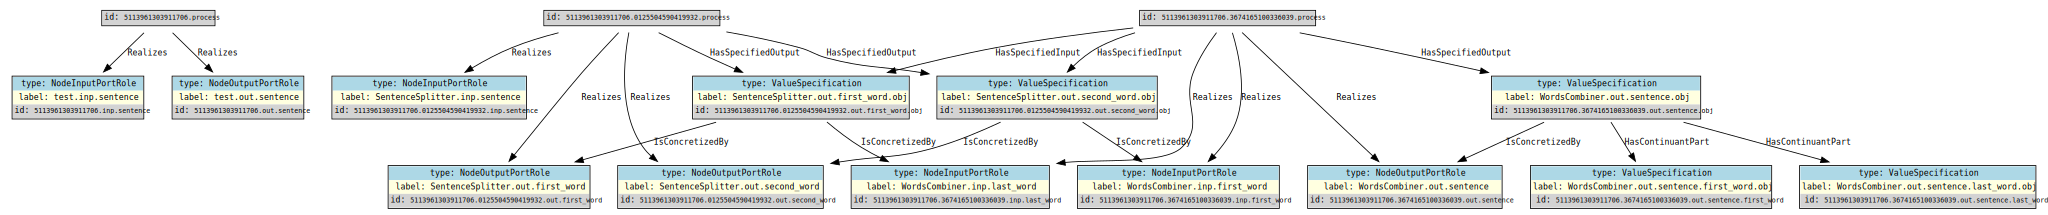

In [23]:
g, workflow_id, node_ids = parse_worklow_recipe(wf=wf_code, parse_nodes=False, parse_software=False, parse_information_flow=True)
g.serialize(destination="test.json", format='json-ld')
pmdco.visualize(g)
#for subj, pred, obj in g:
#    print(subj, pred, obj)

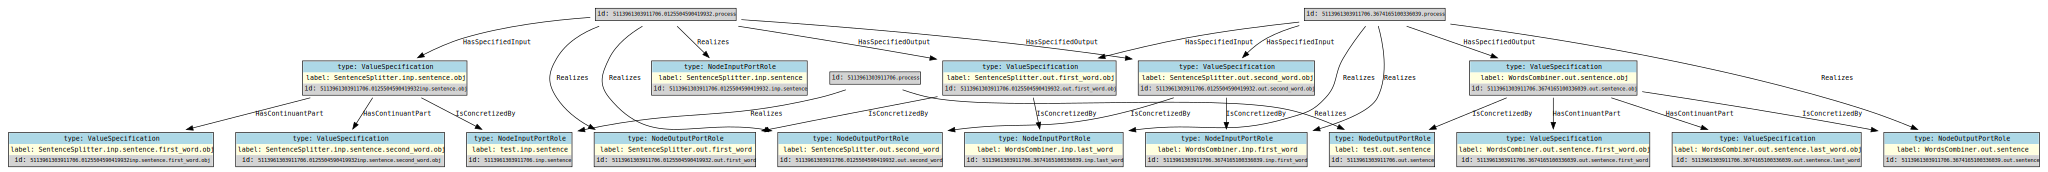

In [24]:
g.add((EX[node_ids["SentenceSplitter"] + "inp.sentence.obj"], RDF.type, pmdco.ValueSpecification().IRI))
g.add((EX[node_ids["SentenceSplitter"] + "inp.sentence.obj"], RDFS.label, rdfLit("SentenceSplitter.inp.sentence.obj")))
g.add((EX[node_ids["SentenceSplitter"] + ".process"], pmdco.HasSpecifiedInput().IRI, EX[node_ids["SentenceSplitter"] + "inp.sentence.obj"]))
g.add((EX[node_ids["SentenceSplitter"] + "inp.sentence.obj"], pmdco.HasContinuantPart().IRI, EX[node_ids["SentenceSplitter"] + "inp.sentence.first_word.obj"]))
g.add((pmdco.HasContinuantPart().IRI, RDFS.label, rdfLit(pmdco.HasContinuantPart.__name__)))
g.add((EX[node_ids["SentenceSplitter"] + "inp.sentence.obj"], pmdco.HasContinuantPart().IRI, EX[node_ids["SentenceSplitter"] + "inp.sentence.second_word.obj"]))
g.add((EX[node_ids["SentenceSplitter"] + "inp.sentence.first_word.obj"], RDF.type, pmdco.ValueSpecification().IRI))
g.add((EX[node_ids["SentenceSplitter"] + "inp.sentence.second_word.obj"], RDF.type, pmdco.ValueSpecification().IRI))
g.add((EX[node_ids["SentenceSplitter"] + "inp.sentence.first_word.obj"], RDFS.label, rdfLit("SentenceSplitter.inp.sentence.first_word.obj")))
g.add((EX[node_ids["SentenceSplitter"] + "inp.sentence.second_word.obj"], RDFS.label, rdfLit("SentenceSplitter.inp.sentence.second_word.obj")))
g.add((EX[node_ids["SentenceSplitter"] + "inp.sentence.obj"], pmdco.IsConcretizedBy().IRI, EX[workflow_id + ".inp.sentence"]))
g.add((EX[node_ids["WordsCombiner"] + ".out.sentence.obj"], pmdco.IsConcretizedBy().IRI, EX[workflow_id + ".out.sentence"]))
#g.add((EX[node_ids["SentenceSplitter"] + ".out.first_word.obj"], pmdco.IsConcretizedBy().IRI, EX[workflow_id + ".out.first_word"]))
#g.add((EX[node_ids["SentenceSplitter"] + ".out.second_word.obj"], pmdco.IsConcretizedBy().IRI, EX[workflow_id + ".out.second_word"]))
pmdco.visualize(g)

In [8]:
@semantikon_class
@dataclass
class generic_semantic_unit:
    type: u(object, pmdco=RDF.type) = None
    label: u(str, pmdco=RDFS.label) = None

@semantikon_class
@dataclass
class software_semantic_unit:
    id: str = None
    type: u(object, pmdco=RDF.type) = None
    label: u(str, pmdco=RDFS.label) = None

@semantikon_class
@dataclass
class node_semantic_unit:
    plan_specification_type: u(object, pmdco=RDF.type) = None
    plan_specification_label: u(str, pmdco=RDFS.label) = None

    process_type: u(object, pmdco=RDF.type) = None
    process_label: u(str, pmdco=RDFS.label) = None

    plan_type: u(object, pmdco=RDF.type) = None
    plan_label: u(str, pmdco=RDFS.label) = None

    software: list[software_semantic_unit] = field(default_factory=lambda: [])

In [10]:
@u(pmdco=node_semantic_unit(plan_specification_type=pmdco.SentenceSplittingNode().IRI,
                            plan_specification_label="example node in my workflow",
                            process_type=pmdco.SentenceSplittingProcess().IRI,
                            process_label="example node in my workflow",
                            plan_type=pmdco.FONDAPlan,
                            plan_label="CRC 1404 FONDA",
                            software = [software_semantic_unit(id="https://www.gnu.org/software/emacs/", type=pmdco.TextEditingSoftware().IRI, label="emacs 30.1"),
                                        software_semantic_unit(type=pmdco.Software().IRI, label="random software"),
                                       ]))
def SentenceSplitterAnnotated(sentence: Sentence) -> typing.Tuple[str,str]:
    first = sentence.first_word
    last = sentence.last_word
    print("Sentence: " + first + " " + last)
    return first, last

pprint(SentenceSplitterAnnotated._semantikon_metadata["pmdco"])

node_semantic_unit(plan_specification_type=rdflib.term.URIRef('https://w3id.org/pmd/co/SentenceSplittingNodePending'),
                   plan_specification_label='example node in my workflow',
                   process_type=rdflib.term.URIRef('https://w3id.org/pmd/co/SentenceSplittingProcessPending'),
                   process_label='example node in my workflow',
                   plan_type=<class 'pmdco.custom.FONDAPlan'>,
                   plan_label='CRC 1404 FONDA',
                   software=[software_semantic_unit(id='https://www.gnu.org/software/emacs/',
                                                    type=rdflib.term.URIRef('https://w3id.org/pmd/co/TextEditingSoftwarePending'),
                                                    label='emacs 30.1'),
                             software_semantic_unit(id=None,
                                                    type=rdflib.term.URIRef('http://purl.obolibrary.org/obo/IAO_0000010'),
                                      

In [26]:
def parse_node_semantic_unit(semantic_unit, node_id):
    if semantic_unit.plan_specification_type is not None:
        print(EX[node_id], meta_to_dict(semantic_unit.__class__.plan_specification_type)["pmdco"], semantic_unit.plan_specification_type)
    if semantic_unit.plan_specification_label is not None:
        print(EX[node_id], meta_to_dict(semantic_unit.__class__.plan_specification_label)["pmdco"], rdfLit(semantic_unit.plan_specification_label))
    if semantic_unit.process_type is not None:
        print(EX[node_id + ".process"], meta_to_dict(semantic_unit.__class__.process_type)["pmdco"], semantic_unit.process_type)
    if semantic_unit.process_label is not None:
        print(EX[node_id + ".process"], meta_to_dict(semantic_unit.__class__.process_label)["pmdco"], rdfLit(semantic_unit.process_label))
    if semantic_unit.plan_type is not None:
        print(EX[node_id + ".process"], meta_to_dict(semantic_unit.__class__.plan_type)["pmdco"], semantic_unit.plan_type)
    if semantic_unit.plan_label is not None:
        print(EX[node_id + ".plan"], meta_to_dict(semantic_unit.__class__.plan_label)["pmdco"], rdfLit(semantic_unit.plan_label))

    if len(semantic_unit.software) > 0:
        for idx, i in enumerate(semantic_unit.software):
            if i.id is not None:
                software_namespace = i.id
            else:
                software_namespace = EX[node_id + ".software" + str(idx)]
            if i.type is not None:
                print(software_namespace, meta_to_dict(i.__class__.type)["pmdco"], i.type)
            if i.label is not None:
                print(software_namespace, meta_to_dict(i.__class__.label)["pmdco"], rdfLit(i.label))
                

parse_node_semantic_unit(SentenceSplitterAnnotated._semantikon_metadata["pmdco"], node_ids["SentenceSplitter"])

http://pyiron_instances.org/5113961303911706.0125504590419932 http://www.w3.org/1999/02/22-rdf-syntax-ns#type https://w3id.org/pmd/co/SentenceSplittingNodePending
http://pyiron_instances.org/5113961303911706.0125504590419932 http://www.w3.org/2000/01/rdf-schema#label example node in my workflow
http://pyiron_instances.org/5113961303911706.0125504590419932.process http://www.w3.org/1999/02/22-rdf-syntax-ns#type https://w3id.org/pmd/co/SentenceSplittingProcessPending
http://pyiron_instances.org/5113961303911706.0125504590419932.process http://www.w3.org/2000/01/rdf-schema#label example node in my workflow
http://pyiron_instances.org/5113961303911706.0125504590419932.process http://www.w3.org/1999/02/22-rdf-syntax-ns#type <class 'pmdco.custom.FONDAPlan'>
http://pyiron_instances.org/5113961303911706.0125504590419932.plan http://www.w3.org/2000/01/rdf-schema#label CRC 1404 FONDA
https://www.gnu.org/software/emacs/ http://www.w3.org/1999/02/22-rdf-syntax-ns#type https://w3id.org/pmd/co/TextE

In [13]:
def parse_node(node_function: Callable, node_type, node_id: str, node_label:str, g: Graph):
    
    try:
        meta_to_dict(node_function)["pmdco"]
    except:
        if node_type == "atomic":
            g.add((EX[node_id], RDF.type, pmdco.DigitalWorkflowAtomicNode().IRI))
            g.add((EX[node_id], RDFS.label, rdfLit(node_label)))
            g.add((pmdco.DigitalWorkflowAtomicNode().IRI, RDFS.label, rdfLit(pmdco.DigitalWorkflowAtomicNode.__name__)))

    try:
        meta_to_dict(node_function)["pmdco"]
    except:
        if node_type == "atomic":
            g.add((EX[node_id + ".process"], pmdco.Executes().IRI, EX[node_id]))
            g.add((EX[node_id + ".process"], RDFS.label, rdfLit(node_label + ".process")))
            g.add((EX[node_id + ".process"], RDF.type, pmdco.DigitalWorkflowAtomicProcess().IRI))
            g.add((pmdco.DigitalWorkflowAtomicProcess().IRI, RDFS.label, rdfLit(pmdco.DigitalWorkflowAtomicProcess.__name__)))

    try:
        meta_to_dict(node_function)["pmdco"]
    except:
        if node_type == "atomic":
            g.add((EX[node_id + ".process"], pmdco.Realizes().IRI, EX[node_id + ".plan"]))
            g.add((pmdco.Realizes().IRI, RDFS.label, rdfLit(pmdco.Realizes.__name__)))
            g.add((pmdco.IsAbout().IRI, RDFS.label, rdfLit(pmdco.IsAbout.__name__)))
            g.add((EX[node_id + ".plan"], RDFS.label, rdfLit(node_label + ".plan")))
            g.add((EX[node_id + ".plan"], RDF.type, pmdco.DigitalWorkflowAtomicPlan().IRI))
            g.add((pmdco.DigitalWorkflowAtomicPlan().IRI, RDFS.label, rdfLit(pmdco.DigitalWorkflowAtomicPlan.__name__)))

    
    return g

In [14]:
def add_software(node_function: Callable, node_type, node_id: str, node_label:str, g: Graph):

    try:
        meta_to_dict(node_function)["pmdco"]
    except:
        g.add((EX[node_id + ".process"], pmdco.Executes().IRI, EX[node_label + "Software0"]))
        g.add((EX[node_label + "Software0"], pmdco.IsAbout().IRI, EX[node_id + ".plan"]))
        g.add((pmdco.Executes().IRI, RDFS.label, rdfLit(pmdco.Executes.__name__)))
        g.add((EX[node_label + "Software0"], RDFS.label, rdfLit("standard-python-lib")))
        g.add((EX[node_label + "Software0"], RDF.type, pmdco.Software().IRI))
        g.add((pmdco.Software().IRI, RDFS.label, rdfLit(pmdco.Software.__name__)))

    try:
        meta_to_dict(node_function)["pmdco"]
    except:
        g.add((EX[node_label + "Env1"], pmdco.HasContinuantPart().IRI, EX[node_label + "Software0"]))
        g.add((EX[node_id + ".process"], pmdco.Executes().IRI, EX[node_label + "Env1"]))
        g.add((pmdco.HasContinuantPart().IRI, RDFS.label, rdfLit(pmdco.HasContinuantPart.__name__)))
        g.add((EX[node_label + "Env1"], RDFS.label, rdfLit("custom_env")))
        g.add((EX[node_label + "Env1"], RDF.type, pmdco.SoftwareEnv().IRI))
        g.add((pmdco.SoftwareEnv().IRI, RDFS.label, rdfLit(pmdco.SoftwareEnv.__name__)))
        
    return

In [15]:
def parse_input_ports(node_function: Callable, node_type, node_id: str, node_label:str, g: Graph):

    for k,v in parse_input_args(node_function).items():
        try:
            (v['pmdco'])
        except:
            g.add((EX[node_id + ".process"], pmdco.Realizes().IRI, EX[node_id + ".inp." + k]))
            g.add((pmdco.Realizes().IRI, RDFS.label, rdfLit(pmdco.Realizes.__name__)))
            g.add((EX[node_id + ".inp." + k], RDF.type, pmdco.NodeInputPortRole().IRI))
            g.add((EX[node_id + ".inp." + k], RDFS.label, rdfLit(node_label + ".inp." + k)))
            g.add((pmdco.NodeInputPortRole().IRI, RDFS.label, rdfLit(pmdco.NodeInputPortRole.__name__)))

def parse_input_objects(node_function: Callable, node_type, node_id: str, node_label:str, g: Graph):

    for k,v in parse_input_args(node_function).items():
        try:
            (v['pmdco'])
        except:
            try:
                if is_dataclass(v["dtype"]):
                    parse_dataclass_object(v["dtype"](), node_id + ".inp", node_label + ".inp", k, g)
                    g.add((EX[node_id + ".process"], pmdco.HasSpecifiedInput().IRI, EX[node_id + ".inp." + k + ".obj"]))
                    g.add((EX[node_id + ".inp." + k + ".obj"], pmdco.IsConcretizedBy().IRI, EX[node_id + ".inp." + k]))
                    g.add((pmdco.HasSpecifiedInput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedInput.__name__)))
                else:
                    parse_simple_object(node_id + ".inp", node_label + ".inp", k, g)
                    g.add((EX[node_id + ".process"], pmdco.HasSpecifiedInput().IRI, EX[node_id + ".inp." + k + ".obj"]))
                    g.add((pmdco.HasSpecifiedInput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedInput.__name__)))
            except:
                parse_simple_object(node_id + ".inp", node_label + ".inp", k, g)
                g.add((EX[node_id + ".process"], pmdco.HasSpecifiedInput().IRI, EX[node_id + ".inp." + k + ".obj"]))
                g.add((pmdco.HasSpecifiedInput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedInput.__name__)))
            
    return

In [16]:
def parse_output_ports_and_objects(node_function: Callable, node_type, node_id: str, node_label:str, out_labels, g: Graph):
                
    if isinstance(parse_output_args(node_function), tuple):
        for idx, i in enumerate(parse_output_args(node_function)):
            try:
                (i['pmdco'])
            except:
                g.add((EX[node_id + ".process"], pmdco.Realizes().IRI, EX[node_id + ".out." + out_labels[idx]]))
                g.add((EX[node_id + ".out." + out_labels[idx]], RDF.type, pmdco.NodeOutputPortRole().IRI))
                g.add((EX[node_id + ".out." + out_labels[idx]], RDFS.label, rdfLit(node_label + ".out." + out_labels[idx])))
                g.add((pmdco.NodeOutputPortRole().IRI, RDFS.label, rdfLit(pmdco.NodeOutputPortRole.__name__)))

            try:
                (i['pmdco'])
            except:
                try:
                    if is_dataclass(i["dtype"]):
                        parse_dataclass_object(i["dtype"](), node_id  + ".out", node_label + ".out", out_labels[idx], g)
                        g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + out_labels[idx] + ".obj"]))
                        g.add((EX[node_id + ".out" + "." + out_labels[idx] + ".obj"], pmdco.IsConcretizedBy().IRI, EX[node_id + ".out." + out_labels[idx]]))
                        g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
                    else:
                        parse_simple_object(node_id  + ".out", node_label + ".out", sout_labels[idx], g)
                        g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + out_labels[idx] + ".obj"]))
                        g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
                except:
                    parse_simple_object(node_id  + ".out", node_label + ".out", out_labels[idx], g)
                    g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + out_labels[idx] + ".obj"]))
                    g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
    else:
        for idx, i in enumerate(parse_output_args(node_function)):
            try:
                parse_output_args(node_function)['pmdco']
            except:
                g.add((EX[node_id + ".process"], pmdco.Realizes().IRI, EX[node_id + ".out." + out_labels[idx]]))
                g.add((EX[node_id + ".out." + out_labels[idx]], RDF.type, pmdco.NodeOutputPortRole().IRI))
                g.add((EX[node_id + ".out." + out_labels[idx]], RDFS.label, rdfLit(node_label + ".out." + out_labels[idx])))
                g.add((pmdco.NodeOutputPortRole().IRI, RDFS.label, rdfLit(pmdco.NodeOutputPortRole.__name__)))

            try:
                parse_output_args(node_function)['pmdco']
            except:
                try:
                    if is_dataclass(parse_output_args(node_function)["dtype"]):
                        parse_dataclass_object(parse_output_args(node_function)["dtype"](), node_id  + ".out", node_label + ".out", out_labels[idx], g)
                        g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + out_labels[idx] + ".obj"]))
                        g.add((EX[node_id + ".out" + "." + out_labels[idx] + ".obj"], pmdco.IsConcretizedBy().IRI, EX[node_id + ".out." + out_labels[idx]]))
                        g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
                    else:
                        parse_simple_object(node_id  + ".out", node_label + ".out", out_labels[idx], g)
                        g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + out_labels[idx] + ".obj"]))
                        g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
                except:
                    parse_simple_object(node_id  + ".out", node_label + ".out", out_labels[idx], g)
                    g.add((EX[node_id + ".process"], pmdco.HasSpecifiedOutput().IRI, EX[node_id + ".out" + "." + out_labels[idx] + ".obj"]))
                    g.add((pmdco.HasSpecifiedOutput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedOutput.__name__)))
            
    return

In [17]:
def make_connections(node: Node, wf_id, node_ids, out_labels, g: Graph):
    for idx, i in enumerate(node.outputs):
        for c in i.connections:
            g.add((EX[node_ids[c.owner.label] + ".process"], pmdco.HasSpecifiedInput().IRI, EX[node_ids[i.owner.label] + ".out" + "." + out_labels[idx] + ".obj"]))
            g.add((EX[node_ids[i.owner.label] + ".out" + "." + out_labels[idx] + ".obj"], pmdco.IsConcretizedBy().IRI, EX[node_ids[c.owner.label] + ".inp." + c.label]))
    return

In [18]:
def parse_dataclass_object(dataclass, indent_id, upper_indent_label, upper_indent_field_name, g: Graph):

    from dataclasses import is_dataclass, fields
    
    try:
        dataclass.__class__._semantikon_metadata
    except:
        g.add((EX[indent_id + "." + upper_indent_field_name + ".obj"], RDF.type, pmdco.ValueSpecification().IRI))
        g.add((EX[indent_id + "." + upper_indent_field_name + ".obj"], RDFS.label, rdfLit(upper_indent_label + "." + upper_indent_field_name + ".obj")))

    for f in fields(dataclass):
        try:
            meta_to_dict(f.type)["dtype"]
            if is_dataclass(meta_to_dict(f.type)["dtype"]):
                parse_dataclass_object(meta_to_dict(field.type)["dtype"](), indent_id + "." + upper_indent_field_name, upper_indent_label + "." + upper_indent_field_name, f.name, g)
            else:
                parse_simple_field(indent_id + "." + upper_indent_field_name, upper_indent_label + "." + upper_indent_field_name, f.name, g)
        except:
            parse_simple_field(indent_id + "." + upper_indent_field_name, upper_indent_label + "." + upper_indent_field_name, f.name, g)
    return

In [19]:
def parse_simple_object(node_id, node_label, port, g: Graph):
    g.add((EX[node_id + "." + port + ".obj"], pmdco.IsConcretizedBy().IRI, EX[node_id + "." + port]))
    g.add((pmdco.IsConcretizedBy().IRI, RDFS.label, rdfLit(pmdco.IsConcretizedBy.__name__)))
    g.add((pmdco.HasSpecifiedInput().IRI, RDFS.label, rdfLit(pmdco.HasSpecifiedInput.__name__)))
    g.add((EX[node_id + "." + port + ".obj"], RDF.type, pmdco.ValueSpecification().IRI))
    g.add((EX[node_id + "." + port + ".obj"], RDFS.label, rdfLit(node_label + "." + port + ".obj")))
    g.add((pmdco.ValueSpecification().IRI, RDFS.label, rdfLit(pmdco.ValueSpecification.__name__)))
    return

In [20]:
def parse_simple_field(indent_id, upper_indent_label, upper_indent_field_name, g: Graph):
    g.add((EX[indent_id + ".obj"], pmdco.HasContinuantPart().IRI, EX[indent_id + "." + upper_indent_field_name]))
    g.add((pmdco.HasContinuantPart().IRI, RDFS.label, rdfLit(pmdco.HasContinuantPart.__name__)))
    g.add((EX[indent_id + "." + upper_indent_field_name], RDF.type, pmdco.ValueSpecification().IRI))
    g.add((EX[indent_id + "." + upper_indent_field_name], RDFS.label, rdfLit(upper_indent_label + "." + upper_indent_field_name + ".obj")))
    return

In [21]:
def parse_node_execution(node: Node, g: Graph):
    return

In [22]:
def parse_workflow_execution(wf: Workflow, g: Graph):
    return